In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [4]:
# 学習データを読み込む
with open("data/input.txt", "r", encoding="utf-8") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Unique chars: {vocab_size}")

# 文字→ID / ID→文字 の対応表
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

# データをテンソル化
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


Unique chars: 53


In [5]:
block_size = 8
batch_size = 16
n_embd = 64
n_head = 4
n_layer = 2
learning_rate = 1e-3
max_iters = 5000
eval_interval = 500

def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [6]:
class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / C**0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, n_embd, block_size):
        super().__init__()
        head_size = n_embd // n_head
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return self.dropout(out)

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size):
        super().__init__()
        self.sa = MultiHeadAttention(n_head, n_embd, block_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=64, block_size=128, n_head=4, n_layer=2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / 1.0
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx
class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / C**0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, n_embd, block_size):
        super().__init__()
        head_size = n_embd // n_head
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return self.dropout(out)

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size):
        super().__init__()
        self.sa = MultiHeadAttention(n_head, n_embd, block_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=64, block_size=128, n_head=4, n_layer=2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / 1.0
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx


In [14]:
model = MiniGPT(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []
for step in range(max_iters):
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        print(f"Step {step:5d} | Loss: {loss.item():.4f}")
        losses.append(loss.item())


Step     0 | Loss: 4.0665
Step   500 | Loss: 0.0428
Step  1000 | Loss: 0.0298
Step  1500 | Loss: 0.0281
Step  2000 | Loss: 0.0220
Step  2500 | Loss: 0.0564
Step  3000 | Loss: 0.0393
Step  3500 | Loss: 0.0489
Step  4000 | Loss: 0.0216
Step  4500 | Loss: 0.0429


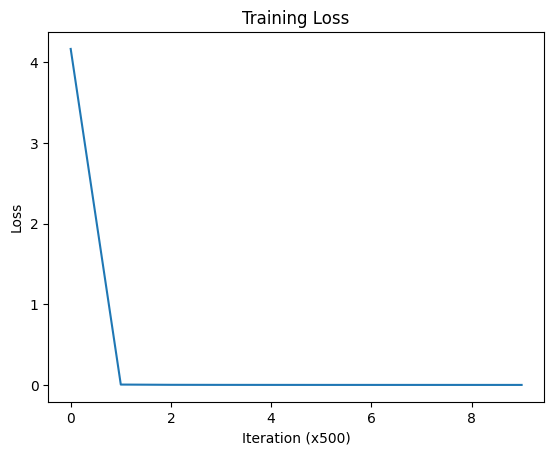

In [18]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration (x500)")
plt.ylabel("Loss")
plt.show()


In [19]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=200)[0].tolist()
print(decode(generated))



これはミニGPTのテストです。
こんにちは晴れです。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機はが降るです。
こんにちは注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注意機は注


# another version


In [20]:
model = MiniGPT(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []
for step in range(max_iters):
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        print(f"Step {step:5d} | Loss: {loss.item():.4f}")
        losses.append(loss.item())


Step     0 | Loss: 4.2169
Step   500 | Loss: 0.0353
Step  1000 | Loss: 0.0279
Step  1500 | Loss: 0.0271
Step  2000 | Loss: 0.0227
Step  2500 | Loss: 0.0185
Step  3000 | Loss: 0.0171
Step  3500 | Loss: 0.0234
Step  4000 | Loss: 0.0265
Step  4500 | Loss: 0.0207


#### block_sizeを増やすと改行されるようになった

In [13]:
block_size= 16
batch_size = 24

In [16]:
# 実行
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=200)[0].tolist()
print(decode(generated))



こんにちは。今日は晴れです。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機います。
Trは注意機nsformerは注意機んにちは。今日は晴れです。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機んにちは。今日は晴れです。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機明日は雨が


#### block_size を更に増やしても効果はなさそうだ

In [19]:
block_size = 24
batch_size = 32

In [21]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=200)[0].tolist()
print(decode(generated))



明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機は注意機は注意機です。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機日は注意機は注意機日は注意機です。
明日は雨が降るでしょう。
AIは文章を学習しています。
Transformerは注意機は注意機はmerは注意機う。
AIは文章を学習しています。
Transformer
